## Regression Outline
We have a set of manually categorized FERC plants with which to test the sklearn Classifier that we're making. We'll also use them to test the regression analysis here. What does this dataset look like, how was it created?
* Pull FERC Plants table.
* Using a variety of search methods, to ensure that we get a wide variety of plants, identify sets of records in the FERC Form 1 Plants table that are comparable inter-year records.


For regressions, both OLS and sklearn approaches are explored.  Plant generation is normalized by using capacity factor.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np

import scipy
import pandas as pd
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from pudl import init, analysis, settings, output
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.constants as pc
import pudl.output.pudltabl
import pudl.analysis.analysis
import matplotlib.pyplot as plt
import matplotlib as mpl
import timezonefinder

%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl()
ferc1_fuel = pudl_out.fuel_ferc1()
ferc1_steam = pudl_out.plants_steam_ferc1()
# eia860_plants =  pudl.output.eia860.plants_eia860()
# eia923_plants =  pudl.output.eia923.plants_eia923()

## Aggregate data from FERC 1 Fuel

In [5]:
# For each plant record in the plants table, we need to be able to assign
# a fraction of heat content for that plant that came from a particlar fuel
# for filtering purposes. There are different ways that we can aggregate that
# information -- e.g. plant_id_pudl, plant_id_ferc1, (utility_id_ferc1, plant_name)
def coal_fraction(fuel_df, gb_cols=['plant_id_pudl']):
    """
    Calculate the fraction of overall heat content from coal
    per year and per gb_cols, which can be:
      - [plant_id_pudl]
      - [plant_id_ferc1]
      - [utility_id_ferc1, plant_name]
    
    Assumes fuel_df is a fuel_ferc1 dataframe.
    Cannot currently work for arbitrary fuel_type becuase not all plants
    have records for all fuel types.
    """
    gb_cols1 = ['report_year'] + gb_cols
    
    # Total heat content across all fuel types
    total_mmbtu = (
        fuel_df.groupby(gb_cols1).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        rename(columns={'fuel_consumed_mmbtu': 'total_mmbtu'})
    )
    
    # Same grouping... but also broken down by fuel type
    gb_cols2 = gb_cols1 + ['fuel_type_code_pudl']
    out_df = (
        fuel_df[fuel_df.fuel_type_code_pudl=='coal'].
        groupby(gb_cols2).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        merge(total_mmbtu, how='left', on=gb_cols1).
        assign(coal_fraction=lambda x: x['fuel_consumed_mmbtu'] / x['total_mmbtu']).
        rename(columns={'fuel_consumed_mmbtu': 'coal_mmbtu'})
    )
    return out_df

In [6]:
ferc_cols_to_keep = ['report_year', 'utility_id_ferc1', 'utility_id_pudl',
                     'utility_name_ferc1', 'plant_id_pudl', 'plant_id_ferc1', 'plant_name', 'plant_type','installation_year',
                     'opex_per_mwh']

In [7]:
# Calculate total heat content of fuel by plant & year
fuel_consumed_mmbtu = (
    ferc1_fuel.loc[ferc1_fuel.report_year>=2012,:].
    groupby(['report_year', 'plant_id_pudl']).
    agg({'fuel_consumed_mmbtu': sum}).
    reset_index()
)

coal_fraction_by_plant_name = coal_fraction(ferc1_fuel.loc[ferc1_fuel.report_year>=2004,:], ['utility_id_ferc1', 'plant_name'])


In [8]:
# New coal fraction estimation using this function - still need to fix column name changes this induces
# coal_fraction_by_plant_name = pudl.transform.ferc1.fuel_by_plant_ferc1(ferc1_fuel)

In [9]:
coal_fraction_by_plant_name.columns

Index(['report_year', 'utility_id_ferc1', 'plant_name', 'fuel_type_code_pudl',
       'coal_mmbtu', 'total_mmbtu', 'coal_fraction'],
      dtype='object')

In [10]:
steam_agg_ferc1 = (
    # Only interested in 2004 and later
    ferc1_steam.loc[ferc1_steam.report_year>=2004,:].
    # This ensures we only include plants that use *some* coal
    merge(coal_fraction_by_plant_name, how='inner', on=['report_year', 'utility_id_ferc1', 'plant_name']).
    # Break out the non-fuel OpEx
    assign(opex_nonfuel=lambda x: x['opex_production_total'] - x['opex_fuel']).
    # Aggregate by plant_id_pudl
    groupby(['report_year','plant_id_pudl']).
    agg({'capacity_mw': sum,
         'net_generation_mwh': sum,
         'opex_fuel': sum,
         'opex_nonfuel': sum,
        'opex_allowances': sum,
        'opex_boiler': sum,
        'avg_num_employees': sum,
         'opex_electric': sum,
         'opex_engineering': sum,
         'opex_misc_power': sum,
         'opex_misc_steam': sum,
         'opex_operations': sum,
         'opex_plants': sum,
         'opex_production_total': sum,
         'opex_rents': sum,
         'opex_steam': sum,
         'opex_steam_other': sum,
         'opex_structures': sum,
         'opex_transfer': sum       
        }).
    reset_index().
    # Bring in total heat content per pudl_plant
    merge(fuel_consumed_mmbtu, how='left', on=['report_year', 'plant_id_pudl']).
    # Calculate some other interesting metrics:
    assign(opex_fuel_per_mwh=lambda x: x['opex_fuel'] / x['net_generation_mwh'],
           opex_nonfuel_per_mwh=lambda x: x['opex_nonfuel'] / x['net_generation_mwh'],
           heat_rate_mmbtu_mwh=lambda x: x['fuel_consumed_mmbtu'] / x['net_generation_mwh'],
           capacity_factor=lambda x: x['net_generation_mwh'] / (8760*x['capacity_mw']),
           opex_total_per_mwh=lambda x: x['opex_nonfuel_per_mwh'] + x['opex_fuel_per_mwh']).
    merge(ferc1_steam[ferc_cols_to_keep],how='left',on=['report_year','plant_id_pudl',])
)

In [11]:
coal_plants = coal_fraction_by_plant_name[coal_fraction_by_plant_name.coal_fraction >= 0.85] # returns ?% of records

In [12]:
coal_plants[coal_plants.plant_name=='dolet hills']

,report_year,utility_id_ferc1,plant_name,fuel_type_code_pudl,coal_mmbtu,total_mmbtu,coal_fraction
27,2004,22,dolet hills,coal,2.634649e+07,2.639074e+07,0.998323
344,2005,22,dolet hills,coal,2.711849e+07,2.711849e+07,1.000000
666,2006,22,dolet hills,coal,2.614793e+07,2.619507e+07,0.998201
990,2007,22,dolet hills,coal,2.110518e+07,2.118594e+07,0.996188
1309,2008,22,dolet hills,coal,2.769405e+07,2.773419e+07,0.998553
1628,2009,22,dolet hills,coal,2.577071e+07,2.584716e+07,0.997042


In [13]:
## This function call replaced by coal fraction calculation
# fuel_df_plant = ferc1_aggregate_by_fuel_type(ferc1_fuel, fuels=['coal'])

In [14]:
new = pd.merge(steam_agg_ferc1, coal_plants, on=['plant_name', 'utility_id_ferc1', 'report_year'], how='right')

In [15]:
new.head(2)

,report_year,plant_id_pudl,capacity_mw,net_generation_mwh,opex_fuel,opex_nonfuel,opex_allowances,opex_boiler,avg_num_employees,opex_electric,opex_engineering,opex_misc_power,opex_misc_steam,opex_operations,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,fuel_consumed_mmbtu,opex_fuel_per_mwh,opex_nonfuel_per_mwh,heat_rate_mmbtu_mwh,capacity_factor,opex_total_per_mwh,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_ferc1,plant_name,plant_type,installation_year,opex_per_mwh,fuel_type_code_pudl,coal_mmbtu,total_mmbtu,coal_fraction
0,2004,1,1010.74,4268739.0,80143963.0,19262788.0,5959.0,9463310.0,99.0,883179.0,975077.0,3751064.0,1018105.0,566528.0,484352.0,99406751.0,0.0,1898592.0,0.0,216622.0,0.0,NaN,18.774622,4.512524,NaN,0.482121,23.287147,164,301,Southwestern Electric Power Company,459,*dolet hills (3),steam,1986.0,24.6,coal,2.159017e+07,2.162697e+07,0.998298
1,2004,1,1010.74,4268739.0,80143963.0,19262788.0,5959.0,9463310.0,99.0,883179.0,975077.0,3751064.0,1018105.0,566528.0,484352.0,99406751.0,0.0,1898592.0,0.0,216622.0,0.0,NaN,18.774622,4.512524,NaN,0.482121,23.287147,22,69,Cleco Power LLC,708,dolet hills,steam,1986.0,22.2,coal,2.634649e+07,2.639074e+07,0.998323


In [16]:
# new.groupby(['report_year','plant_id_pudl', 'capacity_mw', 'net_generation_mwh', 'opex_fuel',
#             'opex_nonfuel','avg_num_employees','opex_production_total','fuel_consumed_mmbtu', 'opex_fuel_per_mwh',
#             'opex_nonfuel_per_mwh','heat_rate_mmbtu_mwh','capacity_factor','opex_total_per_mwh', 'installation_year'], as_index=False).agg({'coal_fraction_mmbtu':sum,
#          'fuel_mmbtu':sum}, as_index=False)

# With previous version of coal_fraction function
new.groupby(['report_year','plant_id_pudl', 'capacity_mw', 'net_generation_mwh', 'opex_fuel',
            'opex_nonfuel','avg_num_employees','opex_production_total','fuel_consumed_mmbtu', 'opex_fuel_per_mwh',
            'opex_nonfuel_per_mwh','heat_rate_mmbtu_mwh','capacity_factor','opex_total_per_mwh', 'installation_year'], as_index=False).agg({'coal_mmbtu': sum,
         'total_mmbtu':sum}, as_index=False);

In [17]:
new.installation_year = pd.to_numeric(new.installation_year, errors='coerce')

In [18]:
# What types of fuel are included in the training data set?
new.plant_type.unique()

array(['steam', 'combustion_turbine', None, 'internal_combustion',
       'nuclear', 'combined_cycle'], dtype=object)

In [19]:
# Look at the anomolous nuclear plant - it's actually coal
new[new.plant_type=='nuclear']

,report_year,plant_id_pudl,capacity_mw,net_generation_mwh,opex_fuel,opex_nonfuel,opex_allowances,opex_boiler,avg_num_employees,opex_electric,opex_engineering,opex_misc_power,opex_misc_steam,opex_operations,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,fuel_consumed_mmbtu,opex_fuel_per_mwh,opex_nonfuel_per_mwh,heat_rate_mmbtu_mwh,capacity_factor,opex_total_per_mwh,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_ferc1,plant_name,plant_type,installation_year,opex_per_mwh,fuel_type_code_pudl,coal_mmbtu,total_mmbtu,coal_fraction
1167,2007,236,991.64,6915236.0,59256251.0,100983818.0,1568348.0,15345478.0,432.0,2637837.0,16204272.0,35817259.0,3755137.0,1864418.0,1639943.0,160240069.0,0.0,7482168.0,0.0,9768378.0,0.0,NaN,8.568941,14.603091,NaN,0.796066,23.172032,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,21.0,coal,3.561636e+07,3.569841e+07,0.997702
1515,2008,236,991.58,6445976.0,56999047.0,118198990.0,1619121.0,19409124.0,456.0,2882772.0,20025268.0,41614235.0,5051814.0,1933758.0,6069879.0,175198037.0,0.0,9905998.0,0.0,4255394.0,0.0,NaN,8.842578,18.336865,NaN,0.742090,27.179443,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,24.1,coal,3.108909e+07,3.115105e+07,0.998011
1858,2009,236,972.85,7405733.0,72803775.0,83117386.0,1161292.0,8428191.0,454.0,2932955.0,11620825.0,39337257.0,3041756.0,2410468.0,1472575.0,155921161.0,0.0,6385438.0,0.0,1735373.0,0.0,NaN,9.830732,11.223384,NaN,0.868997,21.054116,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,17.5,coal,2.915212e+07,2.917190e+07,0.999322
2198,2010,236,972.85,4602948.0,64693238.0,143555962.0,665839.0,39632395.0,394.0,3034134.0,22657600.0,45278687.0,4675188.0,2622245.0,4219829.0,208249200.0,0.0,11122373.0,0.0,3993375.0,0.0,NaN,14.054740,31.187830,NaN,0.540115,45.242571,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,44.7,coal,3.056065e+07,3.059554e+07,0.998859
2529,2011,236,972.85,6932566.0,64339588.0,121714880.0,292584.0,18868442.0,407.0,3301312.0,10217228.0,72290502.0,5132130.0,3077218.0,2326594.0,186054468.0,0.0,224560.0,0.0,1933019.0,0.0,NaN,9.280775,17.556974,NaN,0.813475,26.837749,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,24.1,coal,1.715570e+07,1.722858e+07,0.995770
2860,2012,236,1033.80,5602883.0,54438733.0,206567942.0,89350.0,45394450.0,492.0,3088086.0,17413703.0,91667444.0,4703236.0,3165471.0,20746302.0,261006675.0,0.0,11574131.0,0.0,4183063.0,0.0,7.103493e+06,9.716200,36.868152,1.267828,0.618687,46.584352,17,97,"Duke Energy Progress, Inc.",68,h.b. robinson,nuclear,1971.0,44.6,coal,7.013392e+06,7.103493e+06,0.987316


In [20]:
# Unique plants
# steam_plants = new.sort_values('installation_year').drop_duplicates(subset=['capacity_mw', 'plant_name'], keep='last') # 1007 'plants'
# ct = out_df_ct.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 584 'plants'
# cc = out_df_cc.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 188 'plants'
# ic = out_df_ic.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 147 'plants'
# nuc = out_df_n.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 5 'plants'
# pv = out_df_pv.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 3 'plants'


In [21]:
# # Remove null values for variables of interest, for purposes of histogram plotting
# steam_plants = steam_plants[steam_plants.construction_year.notnull()]
new = new[new.installation_year.notnull()]
new = new.loc[(new['installation_year'] > 1900)]
new = new.loc[(new['capacity_factor']> 0)]

# steam_plants = steam_plants[steam_plants.capacity_mw.notnull()]
# steam_plants = steam_plants[steam_plants.heat_rate.notnull()]

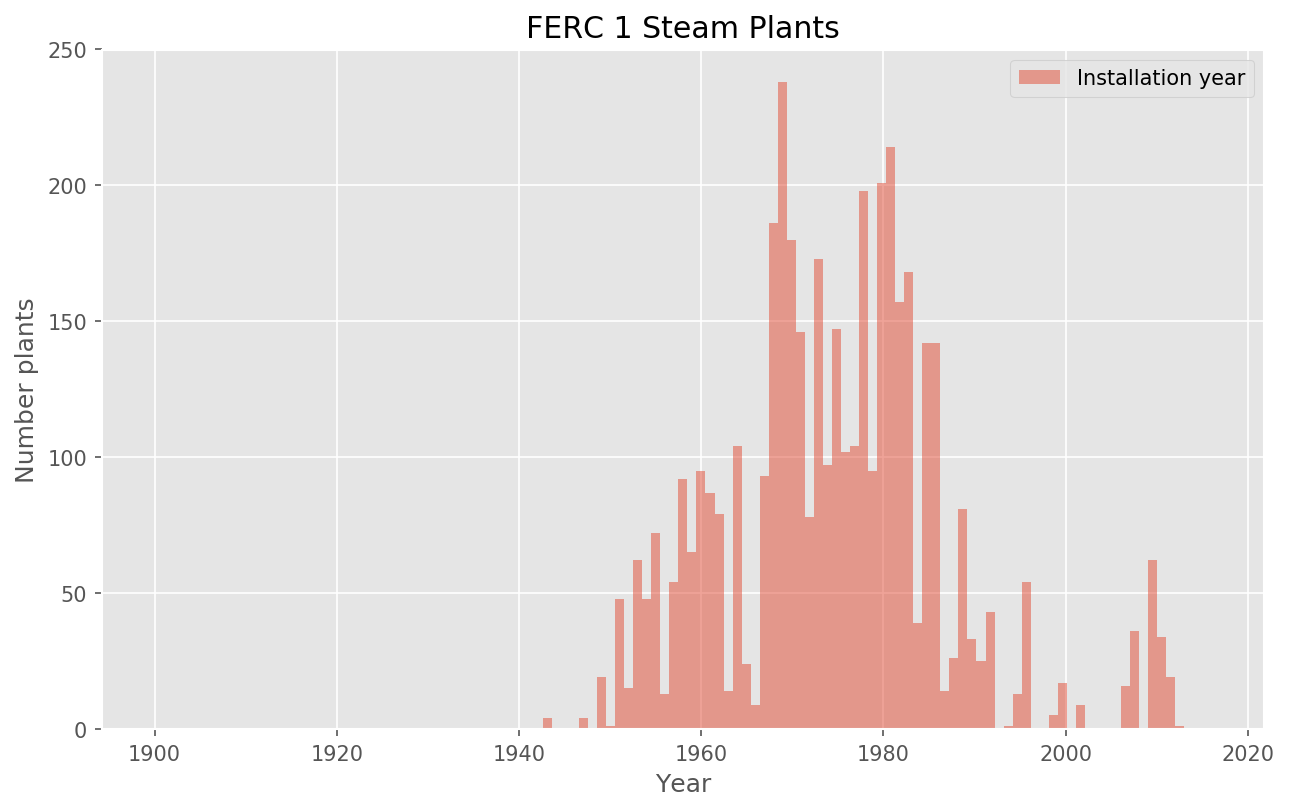

In [22]:
# Look at distribution of construction years vs. installation years.
fig = plt.figure()

plt.xlabel('Year')
plt.ylabel('Number plants')
plt.title('FERC 1 Steam Plants')

# mpl.pyplot.hist(new.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(new.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper right');

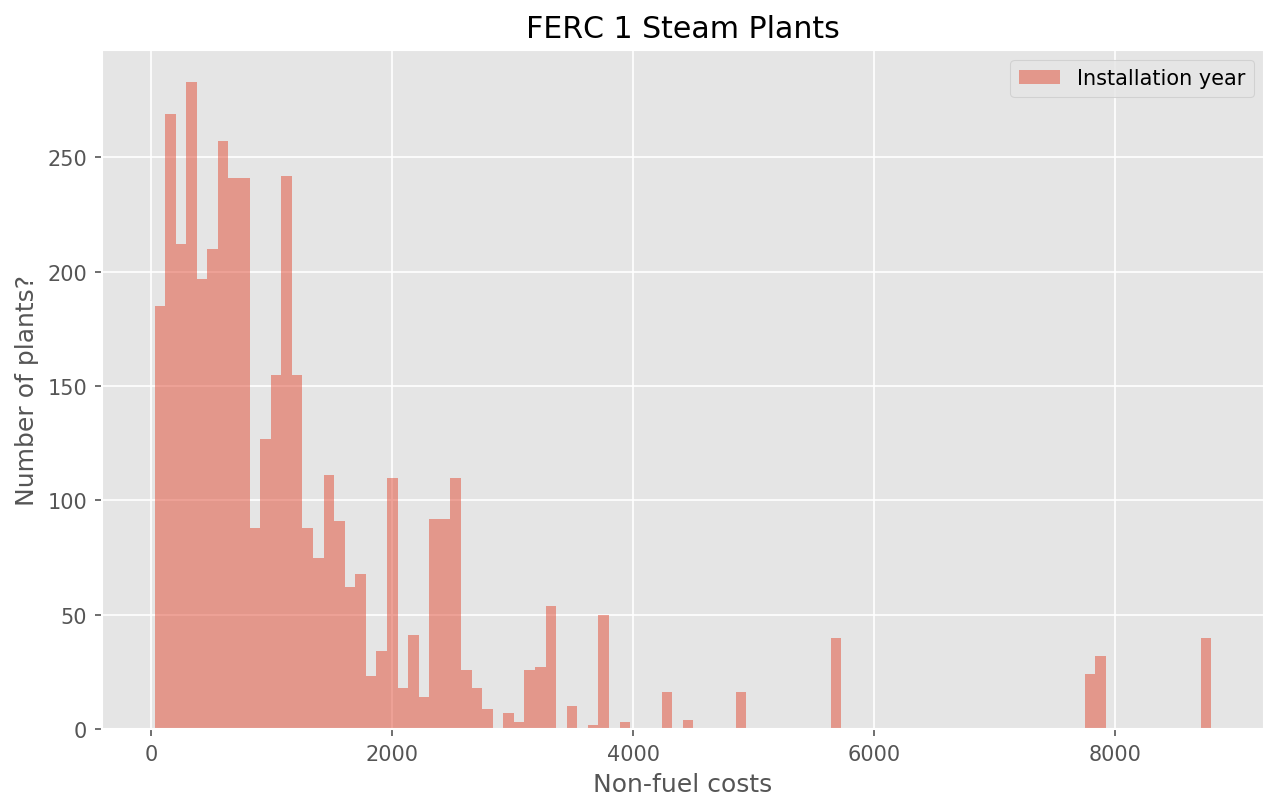

In [23]:
# Look at distribution of construction years vs. installation years.
fig = plt.figure()

plt.xlabel('Non-fuel costs')
plt.ylabel('Number of plants?')
plt.title('FERC 1 Steam Plants')

# mpl.pyplot.hist(new.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(new.capacity_mw, bins = 100, alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper right');

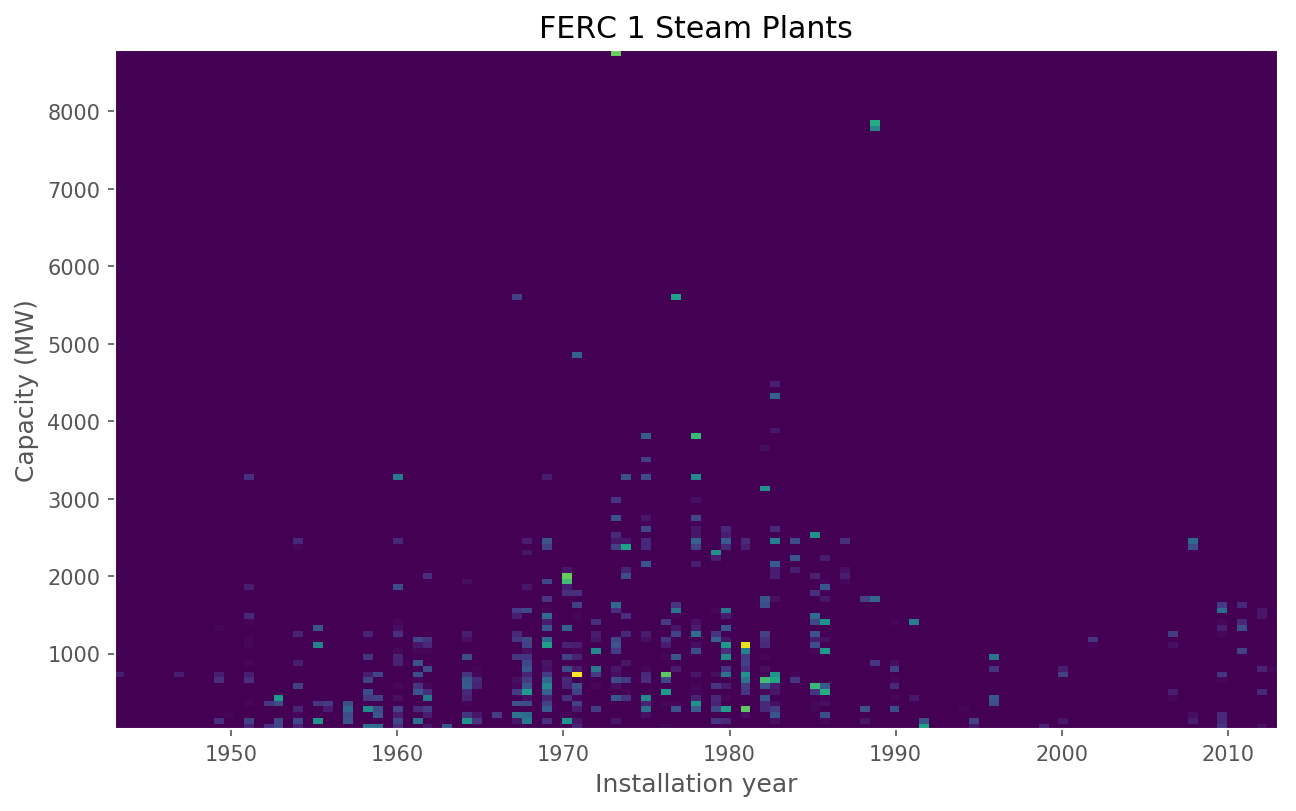

In [24]:
plt.xlabel('Installation year')
plt.ylabel('Capacity (MW)')
plt.title('FERC 1 Steam Plants')
# plt.legend()

mpl.pyplot.hist2d(new.installation_year, new.capacity_mw, bins=117);

# fig.colorbar(im);
#1940 and forward, up to 3K megawatts, just steam - natural groupings?
# install, constru, capacity, and HR then we should find groupings to work wtih.

In [25]:
new.plant_id_pudl.nunique()

248

## Manual binning of construction year, installation year - regressions with statsmodel

In [26]:
oldest = new.loc[(new['installation_year'] < 1956)]
# older = new.loc[(new['installation_year'] >= 1946) & (new['installation_year']< 1956)]
mid = new.loc[(new['installation_year'] >= 1956) & (new['installation_year']< 1966)]
newer = new.loc[(new['installation_year'] >= 1966) & (new['installation_year']< 1986)]
newest = new.loc[new['installation_year'] >= 1986]

In [27]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=new).fit()

# res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh', data=oldest).fit()
# res = sm.OLS.from_formula(formula='opex_nonfuel ~ capacity_mw', data=oldest).fit()


# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)
print(res.summary())

R-squared = 
0.655688296164483

Intercept            -7.479839e+06
net_generation_mwh    2.266859e-01
capacity_mw           4.440581e+04
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           opex_nonfuel   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     4092.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        07:55:11   Log-Likelihood:                -82116.
No. Observations:                4298   AIC:                         1.642e+05
Df Residuals:                    4295   BIC:                         1.643e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P

In [28]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=mid).fit()

# res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh', data=mid).fit()
# res = sm.OLS.from_formula(formula='opex_nonfuel ~ capacity_mw', data=mid).fit()

# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)
print(res.summary())


R-squared = 
0.6604391132082154

Intercept             1.005248e+06
net_generation_mwh    5.924007e-01
capacity_mw           3.565150e+04
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           opex_nonfuel   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     609.8
Date:                Thu, 06 Jun 2019   Prob (F-statistic):          1.63e-147
Time:                        07:55:12   Log-Likelihood:                -11385.
No. Observations:                 627   AIC:                         2.278e+04
Df Residuals:                     624   BIC:                         2.279e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      

In [29]:
res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=newer).fit()

# res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh', data=newer).fit()
# res = sm.OLS.from_formula(formula='opex_nonfuel ~ capacity_mw', data=newer).fit()

# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.7582131558861599

Intercept             4.259000e+06
net_generation_mwh   -1.675723e+00
capacity_mw           4.021040e+04
dtype: float64


In [30]:
# res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh + capacity_mw', data=newest).fit()

# res = sm.OLS.from_formula(formula='opex_nonfuel ~ net_generation_mwh', data=newest).fit()
res = sm.OLS.from_formula(formula='opex_nonfuel ~ capacity_mw', data=newest).fit()


# print(res.params)
print("R-squared = ")
print(res.rsquared_adj)
print("")
print(res.params)

R-squared = 
0.8478313804037859

Intercept     -2.156691e+07
capacity_mw    7.756056e+04
dtype: float64


## sklearn regressions

In [31]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [32]:
train, test = train_test_split(new,test_size=0.2)
# train.fillna(train.mean(), inplace=True)
# train=train.astype('float16')

# test.fillna(test.mean(), inplace=True)
# test=test.astype('float16')

features = ['installation_year', 'heat_rate_mmbtu_mwh', 'capacity_mw', 'capacity_factor', 'opex_fuel_per_mwh','net_generation_mwh']
#features = ['installation_year', 'capacity_mw', 'capacity_factor', 'net_generation_mwh']

y_var='opex_nonfuel'
x_train = train[features]
x_train.fillna(x_train.mean(), inplace=True)
x_train=x_train.astype('float32')
# divided the dollar amount by a million
y_train = train[y_var]/1000000
y_train.fillna(y_train.mean(), inplace=True)
y_train=y_train.astype('float32')

# for testing
x_test = test[features]
x_test.fillna(x_test.mean(), inplace=True)
x_test= x_test.astype('float32')

y_test = test[y_var]/1000000
y_test.fillna(y_test.mean(), inplace=True)
y_test = y_test.astype('float32')

/home/alana/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## scaling the variables

In [33]:
min_max_scaler = preprocessing.MinMaxScaler()
# make sure that the scaler is applied to each col separately
x_train_scaled = min_max_scaler.fit_transform(x_train)
x_test_scaled = min_max_scaler.transform(x_test)

/home/alana/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [34]:
(x_train_scaled[:,1]).mean()

0.0015413346623559991

In [35]:
reg = linear_model.LinearRegression()
reg.fit(x_train_scaled,y_train)

f=reg.coef_
#f=regressorAirTemp.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2_model2=reg.score(x_test_scaled, y_test)

# printing the results of the regression
print ('R^2 of the prediction is {0}'.format(r2_model2))
for i in range(0,len(f)):
    print ('The importance of ', features[i],'-------',round(f[i],3))

R^2 of the prediction is 0.7016583843830411
The importance of  installation_year ------- 43.545
The importance of  heat_rate_mmbtu_mwh ------- -4177.398
The importance of  capacity_mw ------- 336.523
The importance of  capacity_factor ------- -65.58
The importance of  opex_fuel_per_mwh ------- 4161.147
The importance of  net_generation_mwh ------- 75.077


In [36]:
## Extra random forest

In [37]:
# Overfits the data?

from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=200,min_samples_split=5,max_depth=200,random_state=0)
reg.fit(x_train_scaled, y_train)

f=reg.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2_model2=reg.score(x_test_scaled, y_test)

# printing the results of the regression
print ('R^2 of the prediction is {0}'.format(r2_model2))
for i in range(0,len(f)):
    print ('The importance of ', features[i],'-------',round(f[i],3))

R^2 of the prediction is 0.968649988861349
The importance of  installation_year ------- 0.147
The importance of  heat_rate_mmbtu_mwh ------- 0.012
The importance of  capacity_mw ------- 0.599
The importance of  capacity_factor ------- 0.021
The importance of  opex_fuel_per_mwh ------- 0.029
The importance of  net_generation_mwh ------- 0.191


In [38]:
# Unscale the data
# y_new_inverse = scalery.inverse_transform(y_new)

## statmodel

In [39]:
# model = sm.OLS(y_train,x_train_scaled)
X2 = sm.add_constant(x_train_scaled)
model=sm.OLS(y_train, X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           opex_nonfuel   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     1091.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        07:55:14   Log-Likelihood:                -18217.
No. Observations:                3438   AIC:                         3.645e+04
Df Residuals:                    3431   BIC:                         3.649e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8506      3.749     -2.361      0.0

# Further/future regression exlorations - scratch

In [40]:
# # Set up variables for OLS regression 

# # X = new[["net_generation_mwh", "heat_rate"]]
# X = new[["capacity_mw", "net_generation_mwh"]]
# # X = new[["non_fuel_costs"]]
# # X = new[["expns_fuel"]]

# # y = new["opex_fuel"]
# # y = new[["non_fuel_costs"]]
# y = new[["opex_nonfuel"]]

# # y = new[["net_generation_mwh"]]


# X = sm.add_constant(X) ## add an intercept

# model = sm.OLS(y, X).fit()
# predictions = model.predict(X) # make the predictions by the model

# # Print out the statistics
# model.summary()

In [41]:
# # Use sklearn linear_model to fit the same regression
# lm = linear_model.LinearRegression()
# model = lm.fit(X,y)
# predictions = lm.predict(X)
# # print(predictions)[0:5]
# lm.score(X,y)

In [42]:
# scipy.stats.linregress(out_df.net_generation_mwh, out_df.non_fuel_costs)

In [43]:
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
# from sklearn.model_selection import train_test_split

In [44]:
# x = out_df.net_generation_mwh
# y = out_df.non_fuel_costs
# x_reshape = out_df_s.net_generation_mwh.values.reshape(-1,1)
# y_reshape = out_df_s.non_fuel_costs.values.reshape(-1,1)

In [45]:
# intercept, slope, corr_coeff = plot_linear_regression(x_reshape, y_reshape)
# plt.show()


In [46]:
# plt.plot(x,y,'.')
# plt.title('FERC 1 steam records')
# plt.xlabel('net generation (mwh)')
# plt.ylabel('non-fuel costs')

In [47]:
### Exploration of other approaches...

In [48]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0)

In [49]:
# x_train= x_train.values.reshape(-1, 1)
# y_train= y_train.values.reshape(-1, 1)
# x_test = x_test.values.reshape(-1, 1)

In [50]:
# ridge = Ridge(fit_intercept=True, alpha=0.5)

In [51]:
# ridge.fit(x_reshape,y_reshape)

In [52]:
# sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# ferc1_training_steam.net_generation_mwh, ferc1_training_steam.non_fuel_costs)

In [53]:
# clf = sklearn.linear_model.Ridge(alpha=1)
# clf = sklearn.linear_model.Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)

# clf.fit(x_reshape, y_reshape)
# Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=None, solver='auto', tol=0.001)

In [54]:
# result = clf.fit(x_reshape, y_reshape, sample_weight=None)

In [55]:
# clf.score(x_reshape,y_reshape)

In [56]:
# result.get_params()